In [1]:
import csv
import subprocess
import shlex
import json
import re

import numpy as np
import multiprocessing as mp

from io import StringIO
from matplotlib import pyplot as plt
from scipy.stats import kstest, expon, combine_pvalues
from scipy import stats
from IPython.display import display, Markdown
from tqdm import tqdm

In [2]:
import scipy.special as sp

def s_island(A_eff, deme, nu):
    theta_A_eff = (deme * A_eff - 1.0) * nu / (1.0 - nu)
    
    return theta_A_eff * (sp.digamma(theta_A_eff + deme * A_eff) - sp.digamma(theta_A_eff))

def s_island_limit(A_eff, deme, nu):
    return ((A_eff * deme - 1.0) * nu * np.log(1.0 / nu)) / (1.0 - nu)

In [3]:
BIODIVERSITY_PATTERN = re.compile(r"The simulation resulted in a biodiversity of (\d+) unique species\.")
TIMING_PATTERN = re.compile(r"The simulation finished at time (\d+\.\d+) after (\d+) steps\.")
MIGRATION_PATTERN = re.compile(r"There were \d+ migrations to (\d+) ancestors on a finite metacommunity of size \d+ during the simulation\.")

In [4]:
target_directory = json.loads(subprocess.run("cargo metadata --format-version 1".split(), capture_output=True).stdout)["target_directory"]

In [5]:
def simulate_non_spatial_scenario(speciation=0.1, seed=42, size=(10, 10, 10), spatial=False):
    config = "".join(f"""
    (
        speciation: {speciation},
        sample: 1.0,
        seed: {seed},

        algorithm: Classical(),

        log: None,

        scenario: NonSpatial(
            area: ({size[0]}, {size[1]}),
            deme: {size[2]},
            spatial: {str(spatial).lower()},
        ),

        reporters: [
            Plugin(
                library: "{target_directory}/release/deps/libnecsim_plugins_common.so",
                reporters: [Biodiversity()]
            )
        ],
    )
    """.split()).replace(",)", ")").replace(",]", "]")

    # Run the simulation
    result = subprocess.run(shlex.split(
        "cargo run --release --features rustcoalescence-algorithms-monolithic,"
        + f"rustcoalescence-algorithms-independent --quiet -- simulate '{config}'"
    ), check=True, capture_output=True, text=True)

    match = BIODIVERSITY_PATTERN.search(result.stdout)
    biodiversity = int(match.group(1))

    match = TIMING_PATTERN.search(result.stdout)
    time = float(match.group(1))
    steps = int(match.group(2))
        
    return biodiversity, time, steps

In [6]:
def simulate_static_spatially_implicit_scenario(speciation=0.1, seed=42, local=(10, 10, 10), meta=(10, 10, 10), migration=0.1):
    config = "".join(f"""
    (
        speciation: {migration},
        sample: 1.0,
        seed: {seed},

        algorithm: Classical(),

        log: None,

        scenario: NonSpatial(
            area: ({size[0]}, {size[1]}),
            deme: {size[2]},
            spatial: false,
        ),

        reporters: [
            Plugin(
                library: "{target_directory}/release/deps/libnecsim_plugins_metacommunity.so",
                reporters: [
                    Metacommunity(
                        metacommunity: Finite({meta[0]*meta[1]*meta[2]}),
                        seed: {seed},
                    )
                ]
            )
        ],
    )
    """.split()).replace(",)", ")").replace(",]", "]")

    # Run the simulation
    result = subprocess.run(shlex.split(
        "cargo run --release --features rustcoalescence-algorithms-monolithic,"
        + f"rustcoalescence-algorithms-independent --quiet -- simulate '{config}'"
    ), check=True, capture_output=True, text=True)

    match = MIGRATION_PATTERN.search(result.stdout)
    ancestors = int(match.group(1))

    match = TIMING_PATTERN.search(result.stdout)
    local_time = float(match.group(1))
    local_steps = int(match.group(2))
    
    config = "".join(f"""
    (
        speciation: {speciation},
        sample: {ancestors / (meta[0]*meta[1]*meta[2])},
        seed: {seed},

        algorithm: Classical(),

        log: None,

        scenario: NonSpatial(
            area: ({meta[0]}, {meta[1]}),
            deme: {meta[2]},
            spatial: false,
        ),

        reporters: [
            Plugin(
                library: "{target_directory}/release/deps/libnecsim_plugins_common.so",
                reporters: [Biodiversity()]
            )
        ],
    )
    """.split()).replace(",)", ")").replace(",]", "]")
    
    # Run the simulation
    result = subprocess.run(shlex.split(
        "cargo run --release --features rustcoalescence-algorithms-monolithic,"
        + f"rustcoalescence-algorithms-independent --quiet -- simulate '{config}'"
    ), check=True, capture_output=True, text=True)

    match = BIODIVERSITY_PATTERN.search(result.stdout)
    biodiversity = int(match.group(1))

    match = TIMING_PATTERN.search(result.stdout)
    meta_time = float(match.group(1))
    meta_steps = int(match.group(2))
        
    return biodiversity, local_time + meta_time, local_steps + meta_steps

In [7]:
def simulate_dynamic_spatially_implicit_scenario(speciation=0.1, seed=42, local=(10, 10, 10), meta=(10, 10, 10), migration=0.1):
    config = "".join(f"""
    (
        speciation: {speciation},
        sample: 1.0,
        seed: {seed},

        algorithm: Classical(),

        log: None,

        scenario: SpatiallyImplicit(
            local_area: ({local[0]}, {local[1]}),
            local_deme: {local[2]},
            meta_area: ({meta[0]}, {meta[1]}),
            meta_deme: {meta[2]},
            migration: {migration}
        ),

        reporters: [
            Plugin(
                library: "{target_directory}/release/deps/libnecsim_plugins_common.so",
                reporters: [Biodiversity()]
            )
        ],
    )
    """.split()).replace(",)", ")").replace(",]", "]")

    # Run the simulation
    result = subprocess.run(shlex.split(
        "cargo run --release --features rustcoalescence-algorithms-monolithic,"
        + f"rustcoalescence-algorithms-independent --quiet -- simulate '{config}'"
    ), check=True, capture_output=True, text=True)

    match = BIODIVERSITY_PATTERN.search(result.stdout)
    biodiversity = int(match.group(1))

    match = TIMING_PATTERN.search(result.stdout)
    time = float(match.group(1))
    steps = int(match.group(2))
        
    return biodiversity, time, steps

In [8]:
def simulate_almost_infinite_scenario(speciation=0.1, seed=42, radius=18, sigma=10.0, spatial=False):
    config = "".join(f"""
    (
        speciation: {speciation},
        sample: 1.0,
        seed: {seed},

        algorithm: Classical(),

        log: None,

        scenario: AlmostInfinite(
            radius: {radius},
            sigma: {sigma},
        ),

        reporters: [
            Plugin(
                library: "{target_directory}/release/deps/libnecsim_plugins_common.so",
                reporters: [Biodiversity()]
            )
        ],
    )
    """.split()).replace(",)", ")").replace(",]", "]")

    # Run the simulation
    result = subprocess.run(shlex.split(
        "cargo run --release --features rustcoalescence-algorithms-monolithic,"
        + f"rustcoalescence-algorithms-independent --quiet -- simulate '{config}'"
    ), check=True, capture_output=True, text=True)

    match = BIODIVERSITY_PATTERN.search(result.stdout)
    biodiversity = int(match.group(1))

    match = TIMING_PATTERN.search(result.stdout)
    time = float(match.group(1))
    steps = int(match.group(2))
        
    return biodiversity, time, steps

In [9]:
def batch_simulation_many_seeds(simulate, seeds, args=tuple(), kwargs=dict(), silent=False):
    results = []

    with tqdm(total=len(seeds), disable=silent) as progress:
        def update_progress(result):
            results.append(result)

            progress.update()

        with mp.Pool(mp.cpu_count()) as pool:
            for seed in seeds:
                pool.apply_async(simulate, args, {**kwargs, "seed": seed}, update_progress)

            pool.close()
            pool.join()
    
    return results

In [10]:
def confidenceInterval(a, conf=0.95):
    mean = np.mean(a)
    sem = stats.sem(a)
    
    t = stats.t.ppf((1.0 + conf) * 0.5, len(a) - 1)
    
    return mean - t*sem, mean + t*sem

In [11]:
def visualise_biodiversity_time_steps_result(expected, biodiversities, times, steps, conf=0.95):
    low, high = confidenceInterval(biodiversities, conf=conf)

    xmin = np.min(biodiversities)
    xmax = np.max(biodiversities)

    bins = min(21, xmax - xmin + (1 - (xmax - xmin) % 2))

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4))

    ax1.set_title("Biodiversity distribution")
    ax1.set_xlabel("biodiversity")
    ax1.set_ylabel("pdf")
    ax1.hist(biodiversities, bins=bins, density=True, label=(
        f"Observed: {round((low + high) * 0.5, 2)} ± {round((high - low) * 0.5, 2)} ({conf} level)"
    ))
    ax1.axvline(x=expected, color='red', label=f"Expected: {round(expected, 2)}")

    mu, std = stats.norm.fit(biodiversities)
    x = np.linspace(xmin, xmax, 100)
    p = stats.norm.pdf(x, mu, std)
    ax1.plot(x, p, 'k', linewidth=2, label=f"Fitted: mu≈{round(mu, 2)} sigma≈{round(std, 2)}")

    ax1.legend(loc = 'lower center')

    ax2.set_title("Simulation time distribution")
    ax2.set_xlabel("time")
    ax2.set_ylabel("pdf")
    ax2.hist(times, bins=bins, density=True)

    ax3.set_title("Simulation steps distribution")
    ax3.set_xlabel("steps")
    ax3.set_ylabel("pdf")
    ax3.hist(steps, bins=bins, density=True)

    plt.show()

# I. Verify correctness of the NonSpatial scenario
## I.1. Verify that the 'dimensions' of the habitat describe a size

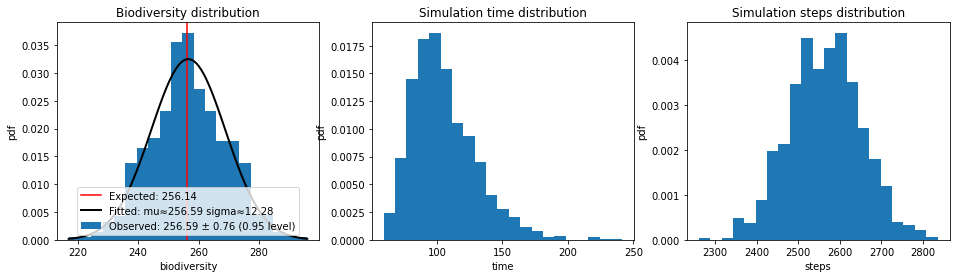

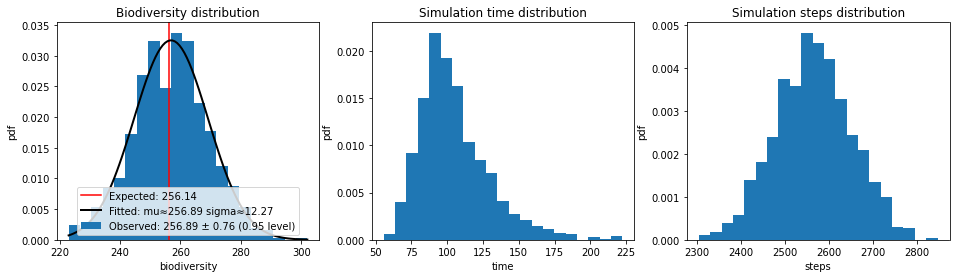

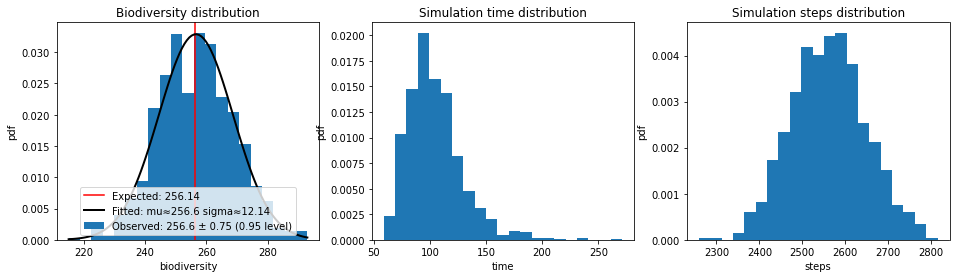

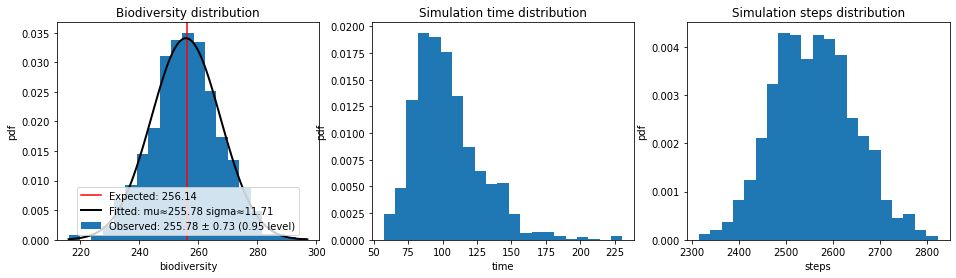

In [12]:
for size in [(10, 10, 10), (1, 100, 10), (10, 1, 100), (100, 10, 1)]:
    seeds = np.random.randint(0, np.iinfo("uint64").max, dtype="uint64", size=1000)

    results = batch_simulation_many_seeds(simulate_non_spatial_scenario, seeds, kwargs={"size":size}, silent=True)
    
    biodiversities, times, steps = tuple(zip(*results))
    
    visualise_biodiversity_time_steps_result(s_island(10*10, 10, 0.1), biodiversities, times, steps)

## I.2. Verify that the `spatial` option does not change the result

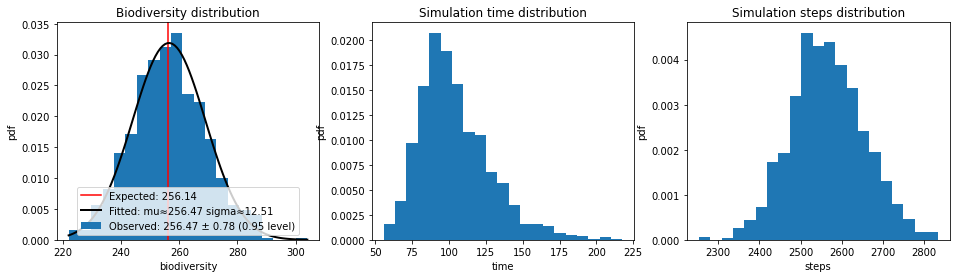

In [13]:
seeds = np.random.randint(0, np.iinfo("uint64").max, dtype="uint64", size=1000)

results = batch_simulation_many_seeds(simulate_non_spatial_scenario, seeds, kwargs={"size":size, "spatial":True}, silent=True)

biodiversities, times, steps = tuple(zip(*results))

visualise_biodiversity_time_steps_result(s_island(10*10, 10, 0.1), biodiversities, times, steps)

## I.3. Verify that the `speciation` rate parameter works

/workspace/.pip-modules/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1835: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


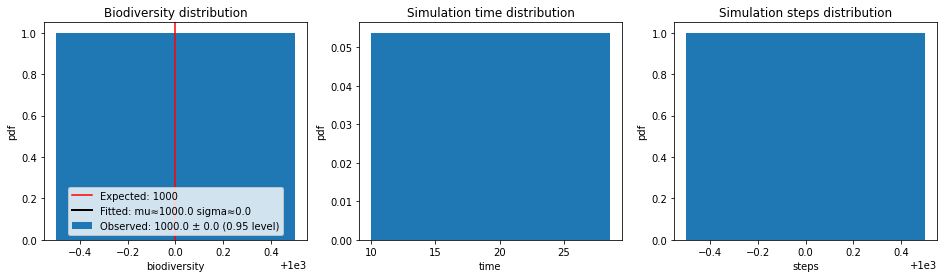

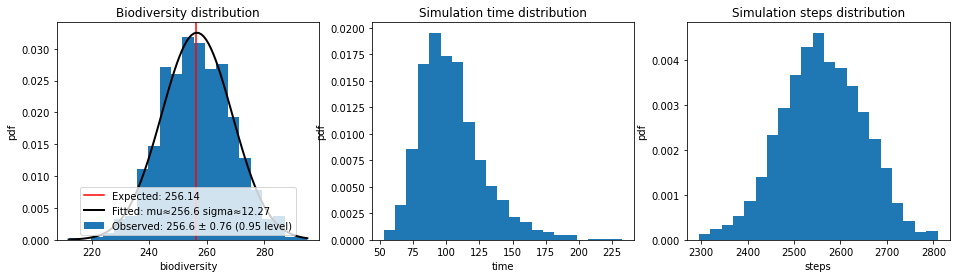

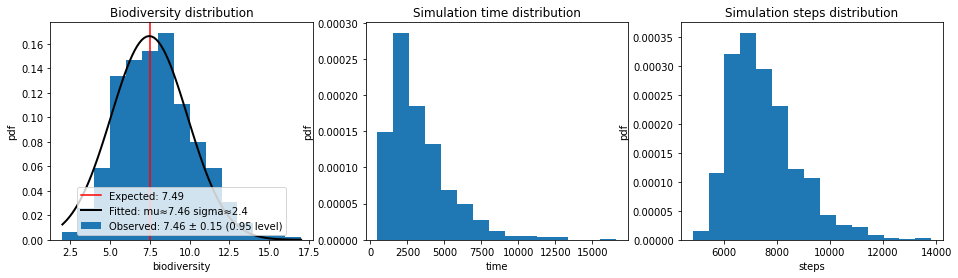

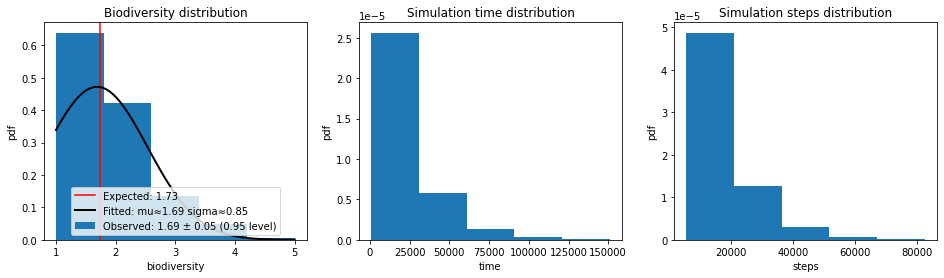

In [14]:
for speciation in [1.0, 0.1, 0.001, 0.0001]:
    seeds = np.random.randint(0, np.iinfo("uint64").max, dtype="uint64", size=1000)

    results = batch_simulation_many_seeds(simulate_non_spatial_scenario, seeds, kwargs={"speciation":speciation}, silent=True)
    
    biodiversities, times, steps = tuple(zip(*results))
    
    visualise_biodiversity_time_steps_result(s_island(10*10, 10, speciation) if speciation < 1.0 else 10*10*10, biodiversities, times, steps)

# ======================================================

1. Correctness of NonSpatial using Classical Algorithm <- exploration-is
2. Correctness of scenarios
3. Correctness of the Algorithms (and their configs) based on a list of NonSpatial scenarios (for now one example) (can include specific tests, s.t. independent is the same even partitioned)